In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install lime

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Base de dados baixada a partir do Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download
df = pd.read_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/creditcard.csv')
# df = pd.read_csv('creditcard.csv') # Versão PC

atributos_a_serem_descartados = ['Time', 'V1', 'V2', 'V6', 'V8', 'V13', 'V15', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
atributos_que_ficaram = ['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'Amount']

#* Atributos importante para a fraude: V3, V4, V5, V7, V9, V10, V11, V12, V14, V16, V17
#* Valores correlacionados negativamente: V17 V14 V12 V10 (Quanto menores mais chances de ser uma fraude)
#* Valores correlacionados positivamente: V2, V4, V11, V19 (Quanto maiores mais chances de ser uma fraude)

#* Atributos importante para o legitimo: V4, Amount

# Atributos que ainda podem ser descartados: V5, V7

print(df.head())

df = df.drop(columns = atributos_a_serem_descartados)

print(df.columns)

X = df.to_numpy()

print(len(X[0]))

y = X[:,-1]
X = X[:,:-1]


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% Treino e 20% Teste
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 20% do treino é Validação

print(f"Tamanho treino: {len(y_train)}, Qtd fraudes: {len(y_train[y_train == 1])}")
print(f"Tamanho validação: {len(y_val)}, Qtd fraudes: {len(y_val[y_val == 1])}")
print(f"Tamanho teste: {len(y_test)}, Qtd fraudes: {len(y_test[y_test == 1])}")

Tamanho treino: 182276, Qtd fraudes: 330
Tamanho validação: 45569, Qtd fraudes: 64
Tamanho teste: 56962, Qtd fraudes: 98


In [63]:
colunas_dataframe = atributos_que_ficaram

df_train = pd.DataFrame(X_train, columns=colunas_dataframe)
df_train['Classe'] = y_train
df_train.to_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/treino.csv')

df_val = pd.DataFrame(X_val, columns=colunas_dataframe)
df_val['Classe'] = y_val
df_train.to_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/validacao.csv')

df_test = pd.DataFrame(X_test, columns=colunas_dataframe)
df_test['Classe'] = y_test
df_train.to_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/teste.csv')

# Uso de OverSample abaixo

Frequencias  [(0.0, 181946), (1.0, 181946)]


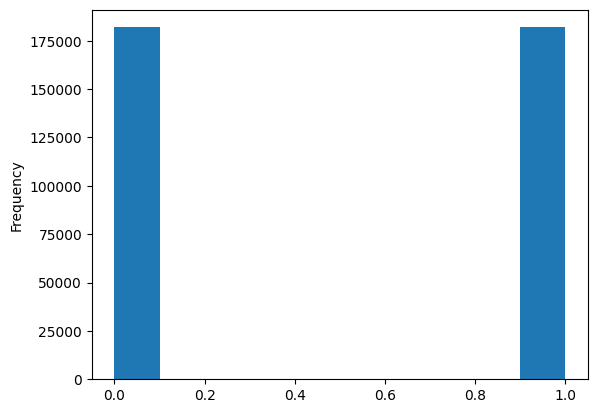

In [16]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from collections import Counter

attributes = pd.DataFrame(X_train)
labels = pd.Series(y_train, name='class')
df_train = pd.concat([attributes, labels], axis=1)

atributos_Smote = df_train.drop('class', axis=1)  # Atributos
classes_Smote = df_train['class']  # Rótulos de classe

smote = BorderlineSMOTE(k_neighbors=3,m_neighbors=2,sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(atributos_Smote, classes_Smote)

df_train_smt = pd.DataFrame(X_smote, columns=df_train.columns)
df_train_smt['class'] = y_smote

#Frequencia das classes com gráfico de barras
freq_class = sorted(Counter(df_train_smt['class']).items())
print('Frequencias ',freq_class)
df_train_smt['class'].plot.hist();

In [10]:
#importando as bibliotecas
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

#Definindo a arquitetura do modelo
#4 (entrada) -> [layer1: 3,layer2: 3](oculta) -> 3 (classes)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim): #Definindo as componentes
        super(MLP, self).__init__()
        self.layerEntry = nn.Linear(input_dim, 13)
        self.layerHidden1 = nn.Linear(13, 8)
        self.layerOut = nn.Linear(8, output_dim)

    def forward(self, x): #Definindo a sequencia de execução das componentes
        x = F.relu(self.layerEntry(x)) #função de ativação F.RELU ou F.sigmoid, ...
        x = F.relu(self.layerHidden1(x))
        x = F.softmax(self.layerOut(x), dim=1)
        return x

In [11]:
#Criando o modelo
num_atributes = X_train.shape[1] #Número de objetos no conjunto de treino
num_classes = len(np.unique(y_train)) #Número de classes do conjunto de Treinamento (E SE A AMOSTRAGREM DO TREINO NÃO TEM TODAS AS CLASSES? DA RUIM!)

#Criando o Modelo
model= MLP(num_atributes,num_classes)

#Método para calcular o GRADIENTE e ATUALIZAR pesos (otimizadores)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Funções de Erro:
loss_fn   = nn.CrossEntropyLoss() #Entropia Cruzada

print(model)
print(model.layerHidden1.weight)


MLP(
  (layerEntry): Linear(in_features=13, out_features=13, bias=True)
  (layerHidden1): Linear(in_features=13, out_features=8, bias=True)
  (layerOut): Linear(in_features=8, out_features=2, bias=True)
)
Parameter containing:
tensor([[ 0.0656, -0.1441,  0.2600, -0.0830,  0.0808, -0.2035,  0.2490, -0.0840,
          0.2358, -0.0304, -0.2378,  0.2224,  0.1182],
        [ 0.2505, -0.1895, -0.0603, -0.2380, -0.1889,  0.1843, -0.0443,  0.1519,
          0.1503, -0.1933,  0.1923, -0.1319, -0.2416],
        [-0.0343,  0.1766,  0.0329, -0.1675, -0.1661,  0.1968, -0.1680, -0.1668,
          0.1534, -0.2061,  0.0063,  0.0756, -0.0936],
        [-0.0362,  0.2495,  0.1363, -0.0858, -0.0213,  0.2001,  0.1826,  0.2386,
          0.1577, -0.1973, -0.0432,  0.0270, -0.2519],
        [ 0.0596,  0.1301, -0.0584, -0.0398,  0.2670,  0.0413,  0.2046, -0.0357,
         -0.2447,  0.0273,  0.1576,  0.1918,  0.1040],
        [-0.1359, -0.0350,  0.1889,  0.1599,  0.2039,  0.2454,  0.2349, -0.0770,
         -0.

In [12]:
#Criando a estrutura de dados para o PYTORCH (Variable -> Tensor)
X_trainT = Variable(torch.from_numpy(X_smote.to_numpy())).float()
y_trainT = Variable(torch.from_numpy(y_smote.to_numpy())).long()

X_valT = Variable(torch.from_numpy(X_val)).float()
y_valT = Variable(torch.from_numpy(y_val)).long()

X_testT  = Variable(torch.from_numpy(X_test)).float()
y_testT  = Variable(torch.from_numpy(y_test)).long()

In [13]:
#Treinamento do Modelo
from sklearn import preprocessing
import tqdm

EPOCHS  = 500
min_loss = 100000
best_epoch = -1

loss_train   = np.zeros((EPOCHS,))
loss_val     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_trainT)
    loss = loss_fn(y_pred, y_trainT)
    loss_train[epoch] = loss.item()

    optimizer.zero_grad()# Zerando os valores de Gradiente para não serem considerados da época anterior
    loss.backward() # Calculando o Gradiente
    optimizer.step() # Atualizando os paramentros da rede

    with torch.no_grad(): # Aplicando o conjunto de validação
        y_pred = model(X_valT)
        loss = loss_fn(y_pred, y_valT)
        loss_val[epoch] = loss.item()
        if loss_val[epoch] < min_loss:
          best_epoch = epoch
          min_loss = loss_val[epoch]
        correct = (torch.argmax(y_pred, dim=1) == y_valT).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

print('\nMenor erro da Validação: ',min_loss,' EPOCA ',best_epoch)

100%|██████████| 500/500 [01:29<00:00,  5.59it/s]


Menor erro da Validação:  0.31939759850502014  EPOCA  499


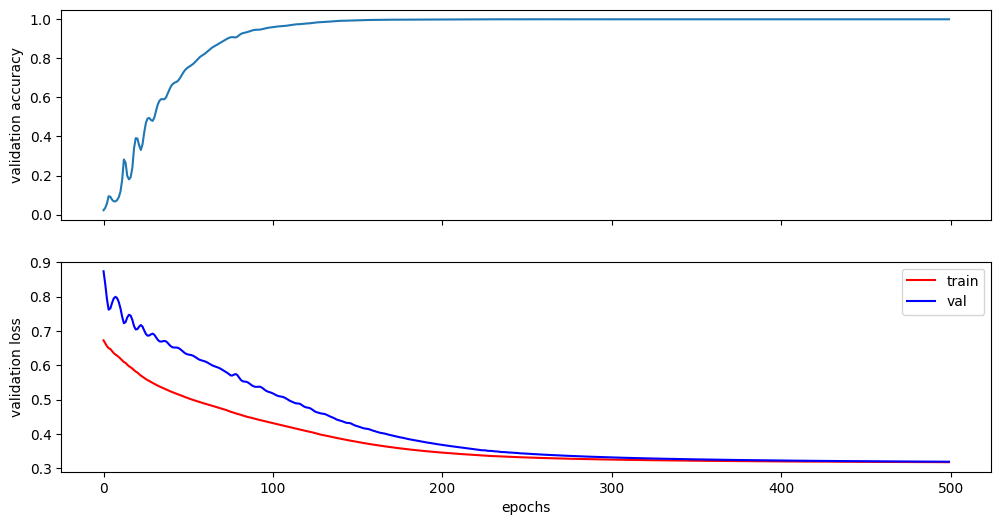

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_train,'-r',label='train')
ax2.plot(loss_val,'-b',label='val')
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
ax2.legend();

In [24]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_smote, y_smote)

Acertos: 45546/45569
0.9994952709078541


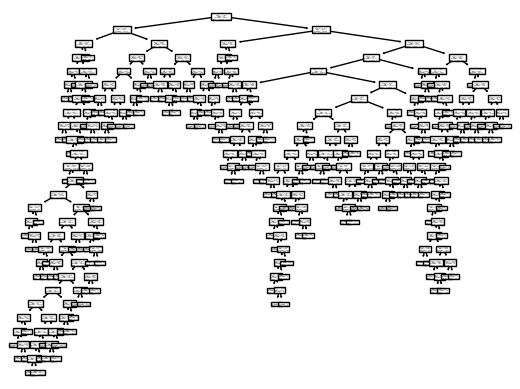

In [31]:
validacao = clf.predict(X_val)

contador_acertos = 0

for i in range(len(X_val)):
  if validacao[i] == y_val[i]:
    contador_acertos += 1

print(f"Acertos: {contador_acertos}/{len(X_val)}")
print(contador_acertos/len(X_val))

tree.plot_tree(clf);

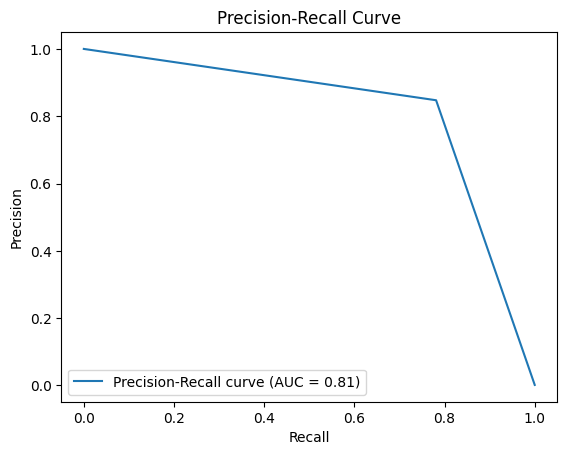

In [34]:
from sklearn.metrics import precision_recall_curve, auc

#validacao = model(X_valT) # Pytorch e tensor
validacao = clf.predict(X_val)

#Calculando os valores de Precision e Recall
#precision, recall, _ = precision_recall_curve(y_val, torch.argmax(validacao, dim=1)) # Pytorch e tensor
precision, recall, _ = precision_recall_curve(y_val, validacao)
#Calculando area sobre a curva que plota Precision vs Recall
auc_pr = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (AUC = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

cm_viz = ConfusionMatrix(model)
cm_viz.score(X_val, y_val)
cm_viz.show();

YellowbrickTypeError: ignored

Accuracy: 0.9996708288529482


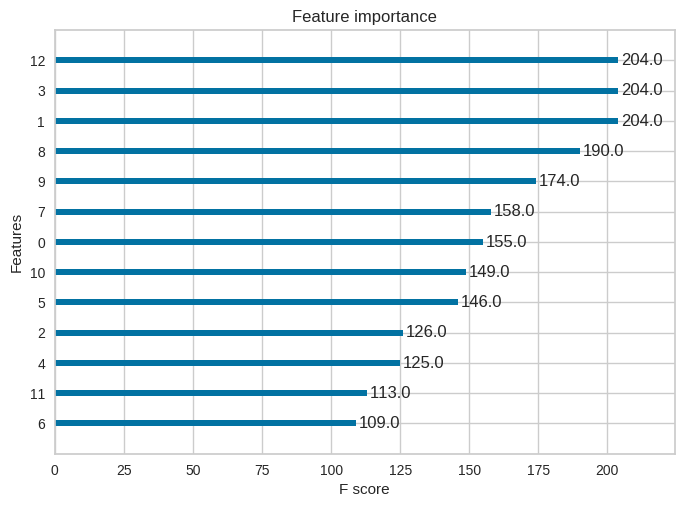

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier()
model.fit(X_smote, y_smote)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

xgb.plot_importance(model)
plt.show()

# Atributos que estão na base filtrada
# OBS: Se rodar novamente checkar se são esses atributos mesmos
#     "V3": 0,
#     "V4": 1,
#     "V5": 2,
#     "V7": 3,
#     "V9": 4,
#     "V10": 5,
#     "V11": 6,
#     "V12": 7,
#     "V14": 8,
#     "V16": 9,
#     "V17": 10,
#     "V19": 11,
#     "Amount": 12